This script examines the relationship between Truck Speed Data and Average Annual Daily Traffic (AADT) in Eastern Ontario. Data has been provided through MTO's iCorridor open source database. The data has been cleaned and manipulated through QGIS software then saved as a geopackage for data analyses

In [9]:
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
import matplotlib as mpl
import matplotlib.ticker as ticker
from scipy import stats
from sklearn.metrics import r2_score
wdir = r'C:\Users\JACCHAN\HDR, Inc\MTO Eastern Ontario - Provincewide Plan - Documents\5.0_Proj_Dev\Data Analysis\Reliability\BTI and TTI Plots'
# file_name_car = '2019truck_vs_2016treso_factored.gpkg'
file_name_car = '2019 Trucks Speed Join 2019 AADT3.gpkg'
data_raw = gpd.read_file(wdir + '\\' + file_name_car)

Regression models were defined.

In [10]:
def f(x,  m, b):
    return m*x + b

def fpower (x, b, c):
    return 1 + b*x**c

The regression models above were used in the following regression functions

In [11]:
def LinRegr(df,x_df_colname, y_df_colname):
    #Curve Fitting
    x = df[x_df_colname]
    y = df[y_df_colname]
    popt, pcov = curve_fit(f,x,y)
    # calculated r_squared
    #https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    residuals = y - f(x, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res/ss_tot)
    #for aesthetics
    if popt[1] < 0:
        regr_eq = 'y = ' + "{:.3e}".format(popt[0]) + '(x) - ' + "{:.2f}".format(abs(popt[1]))
    else:
        regr_eq = 'y = ' + "{:.3e}".format(popt[0]) + '(x) + ' + "{:.2f}".format(popt[1])
    return r_squared, regr_eq, popt[0], popt[1]

def PowRegr(df,x_df_colname, y_df_colname):
    x = df[x_df_colname]
    y = df[y_df_colname]
    popt, pcov = curve_fit(fpower,x,y, maxfev=5000)
    # calculated r_squared
    #https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    residuals = y - fpower(x, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res/ss_tot)
    regr_eq = 'y = 1' +' + ' + "{:.3e}".format(popt[0]) + '(x)^' + "{:.2f}".format(popt[1])
    return r_squared, regr_eq, popt

Function made for plotting linear and power-curve regression because multiple plots will be made.

In [12]:
def PlotLinRegr (df, x_df_colname, y_df_colname, xtitle, ytitle, title, colorindex):
    fig = plt.figure()
    ax = sns.regplot(data=df, x = x_df_colname, y = y_df_colname,
                color = sns.color_palette()[colorindex],
                ci = None)
    # ax.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.title(title) #+ '\n' + str(j) + 'LANES')
    plt.text(0.05,0.95, regr_eq, 
             ha = 'left',
             va = 'center', 
             transform = plt.gca().transAxes)
    plt.text(0.05,0.9, 'r_squared = ' + "{:.3f}".format(r_squared),
             ha = 'left',
             va = 'center',
             transform = plt.gca().transAxes)
    plt.xlim(left = 0)
    # plt.ylim(bottom = 0)
    return fig
def PlotPowRegr(df, x_df_colname, y_df_colname, xtitle, ytitle, title, colorindex):
    fig = plt.figure()
    ax = sns.scatterplot(data=df, x = x_df_colname, y = y_df_colname,
                color = sns.color_palette()[colorindex],
                ci = None)
    # ax.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.title(title) #+ '\n' + str(j) + 'LANES')
    plt.text(0.05,0.95, regr_eq, 
             ha = 'left',
             va = 'center', 
             transform = plt.gca().transAxes)
    plt.text(0.05,0.9, 'r_squared = ' + "{:.3f}".format(r_squared),
             ha = 'left',
             va = 'center',
             transform = plt.gca().transAxes)
    plt.xlim([0,70000])

    # plt.ylim(bottom = 0)
    return fig

making new dataframe with non-null AADT values then dividing AADT by number of lanes.

In [13]:
data_mod = data_raw[data_raw['AADT19'].notnull()].copy(deep = True)
data_mod['AADT19_adj'] = data_mod['AADT19']/data_mod['LANES']

The data was grouped-by and the median was taken because the road segments in the 2019 shapefile contains multiple segments of truck speed data. 

In [14]:
data_mod_bti = data_mod.groupby(['FID_AADT',]).median()
data_mod_tti = data_mod.groupby(['FID_AADT',]).median()
#list of periods for for-loop
bti_period = ['BTI_AM', 'BTI_PM', 'BTI_WN']                                   
tti_period = ['TTI_AM', 'TTI_PM', 'TTI_WN']  

Finding min and maxes for plots to have consistent scales for better comparison

In [15]:
bti_min = []
bti_max = []
for i, j in enumerate(bti_period):
    df4 = data_mod_bti[(np.abs(stats.zscore(data_mod_bti[j])) < 3)] # initial filtering
    df4 = df4[df4['AADT19_adj']>= 10000]
    bti_min.append(df4[j].min())
    bti_max.append(df4[j].max())
tti_min = []
tti_max = []
for i, j in enumerate(tti_period):
    df4 = data_mod_tti[(np.abs(stats.zscore(data_mod_tti[j])) < 3)] # initial filtering
    df4 = df4[df4['AADT19_adj']>= 10000]
    tti_min.append(df4[j].min())
    tti_max.append(df4[j].max())

if min(bti_min) > 1:
    bti_min = 1
else:
    bti_min = min(bti_min) -0.05
if min(tti_min) > 1:
    tti_min = 1
else:
    tti_min = min(tti_min)-0.05
bti_max = max(bti_max)+0.2
tti_max = max(tti_max)+0.2             

Plotting Power Curve Regression for AADT-per-lane values greater than 10,000. AADT-per-lane less than 10,000 were previously examined to chaotic and do not have patterns.

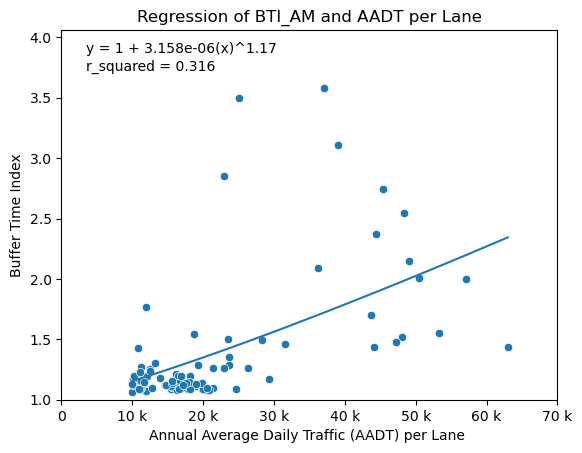

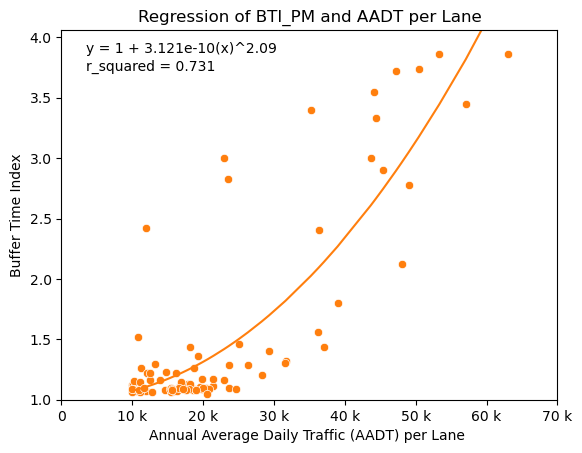

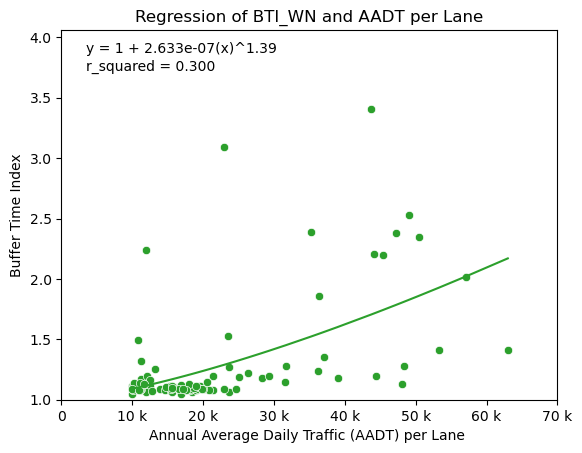

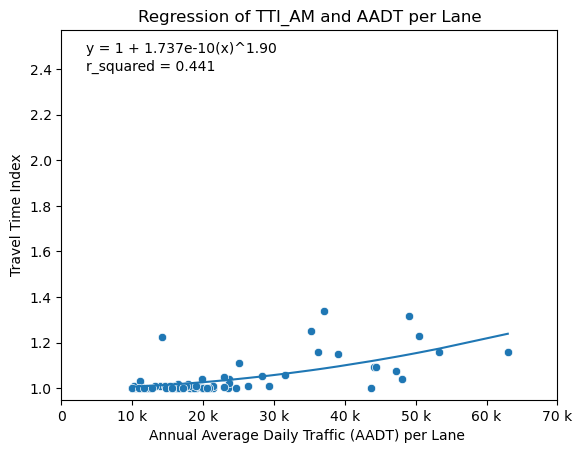

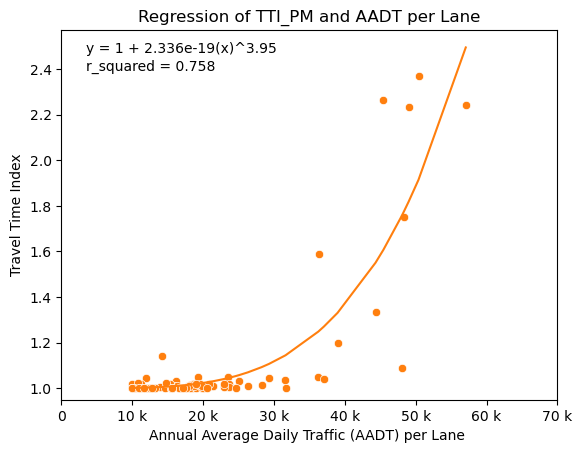

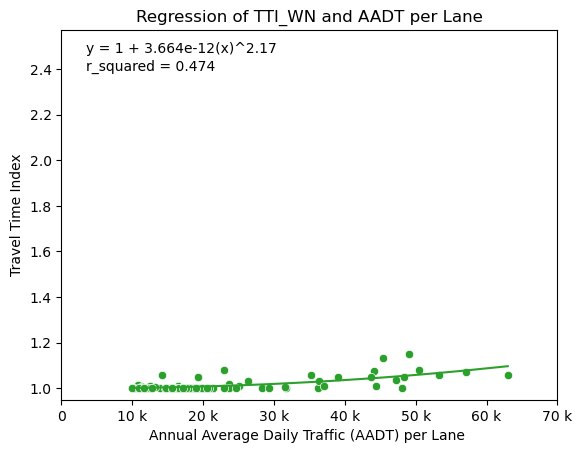

In [16]:
for i, j in enumerate(bti_period):    
    df4 = data_mod_bti[(np.abs(stats.zscore(data_mod_bti[j])) < 3)] # initial filtering
    # outlier removing based on engineering judgement
    df4 = df4[df4['AADT19_adj']>= 10000]
    if j== 'BTI_AM':
        df5 = df4[(df4[j] < 1) ]#| (df4[j]> 3)]
        df4 = df4[(df4[j]>= 1) ]#& (df4[j]<=3) ]
    elif j== 'BTI_WN':
        df5 = df4[(df4[j] < 1) ]#| (df4[j]> 3)]
        df4 = df4[(df4[j]>= 1) ]#& (df4[j]<=3) ]
    else:
        df5 = df4[df4[j] < 1]
        df4 = df4[(df4[j]>= 1) ]
    r_squared, regr_eq, cof = PowRegr(df4, 'AADT19_adj',j)
    xlabel = "Annual Average Daily Traffic (AADT) per Lane "
    ylabel = "Buffer Time Index"                
    titlelabel = ('Regression of ' 
                  + j 
                  + ' and AADT per Lane')
    #plotting filtered data
    fig = PlotPowRegr(df4,'AADT19_adj', j, xlabel,ylabel,titlelabel,i)
    #plotting line of best fit
    xplot = df4['AADT19_adj'].sort_values(ascending = True)
    yplot = 1 + cof[0]*xplot**cof[1]
    plt.plot(xplot, yplot, color = sns.color_palette()[i] )  
    xplot2 = df5['AADT19_adj']
    yplot2 = df5[j]
    plt.scatter(xplot2, yplot2, color = 'r', marker = 'x')
    plt.ylim([bti_min,bti_max])
    
for i, j in enumerate(tti_period):    
    df4 = data_mod_tti[(np.abs(stats.zscore(data_mod_tti[j])) < 3)] # initial filtering
    df4 = df4[df4['AADT19_adj']>= 10000]
    #outlier removing based on engineering judgement 
    if j == 'TTI_AM':
        df5 = df4[(df4[j] < 1) ]#| (df4[j]> 3)]
        df4 = df4[(df4[j]>= 1) ]#& (df4[j]<=3) ]
    elif j == 'TTI_PM':
        df5 = df4[(df4[j] < 1)]
        df4 = df4[(df4[j]>= 1)]

    else:
        df5 = df4[df4[j] < 1]
        df4 = df4[df4[j] >= 1]
    r_squared, regr_eq, cof = PowRegr(df4, 'AADT19_adj',j)
    xlabel = "Annual Average Daily Traffic (AADT) per Lane "
    ylabel = "Travel Time Index"                
    titlelabel = ('Regression of ' 
                  + j 
                  + ' and AADT per Lane')
    #plotting filtered data
    fig = PlotPowRegr(df4,'AADT19_adj', j, xlabel,ylabel,titlelabel,i)
    # plt.ylim([0.5, 3])
    #plotting line of best fit
    xplot = df4['AADT19_adj'].sort_values(ascending = True)
    yplot = 1 + cof[0]*xplot**cof[1]
    plt.plot(xplot, yplot, color = sns.color_palette()[i] )
    xplot2 = df5['AADT19_adj']
    yplot2 = df5[j]
    plt.scatter(xplot2, yplot2, color = 'r', marker = 'x')
    plt.ylim([tti_min,tti_max])